In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
from numpy import random
from scipy.stats import lognorm
from scipy.integrate import fixed_quad
from scipy import interpolate
from scipy.optimize import fminbound
from scipy.optimize import minimize

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
#import plotly.plotly as py
#import plotly.graph_objs as go
#from plotly import __version__
#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

#from numba import jit
#ipcluster nbextension enable

In [333]:
class DynamicProgrammingSquaredModel:
    """
    Docstrings
    """
    
    def __init__(self,
                β = 0.8 ,
                γ = 0.9,
                τ = 0.2,
                μ = 0,
                s = 0.1,
                α = 0.5,
                δ = 0.1,
                θ = 0.9,
                seed = 100,
                shock_size = 100 ,
                y_min = 1e-5,
                y_max = 5,
                y_grid_size = 100
                ):
        #### Assigning Parameters
        
        # Model Parameters
        self.β, self.γ, self.τ = β, γ, τ
        
        # State Function G Parameters assignement
        self.α, self.δ, self.θ = α, δ, θ
        
        # Shocks Parameters
        self.s, self.μ, self.shock_size, self.seed  = s, μ, shock_size, seed
        
        #Setting up shocks in the models
        np.random.seed(self.seed) # setting seed to generate same random numbers
        self.shocks = np.exp( self.μ + self.s * np.random.randn(self.shock_size)  )
        
        #Y Grid State Allocation
        self.y_min, self.y_max, self.y_grid_size  = y_min, y_max, y_grid_size
        self.y_grid = np.linspace(self.y_min, self.y_max, self.y_grid_size)
        
    
    def initial_v(self):
        return np.sqrt(self.y_grid)
        #return self.y_grid
        #return 10*np.log(self.y_grid)
        
    
    def U(self,y,k,τ):
        'Calculates utility of Agents'
        return np.power( (1-τ)*y-k ,0.9)
    
    
    def W(self,y,x,τ):
        'Calculates the utility of Principal(Government)'
        return np.power(τ*y - x,0.9)
    
    
    def G(self, y,x, k):
        'G is state transition function'
        return (y**self.α+ x**self.θ + k**self.δ )*self.shocks
    
    
    def bellman_operator_v(self, v, x = 0, τ = 0, Tv = None):
        """
        It runs of consumers utility equation
        """
        ### Applying Linear Interpolation
        fv = interpolate.interp1d(self.y_grid, v,fill_value='extrapolate')
        
        # Intialized Compute policy if needed
        σ_v = np.empty_like(v)
        
        ## Intialized Tv if necessary ###
        if Tv is None:
            Tv = np.empty_like(v)
    
        # Set Tv[i] = max_k { u[ (1-τ)y - k ] + β E[ v( G(y, x,k,z) ) ] }
        for i, y in enumerate(self.y_grid):
            def objective(k):
                return -self.U(y = y, k = k, τ = τ) - self.β*np.mean( fv( self.G(y = y, x =x, k = k) ) )
            k_star = fminbound(objective, 1e-10, (1-τ)*y  )
            σ_v[i] = k_star
            Tv[i] = - objective(k_star)
        
        return Tv, σ_v
    
   
    def solve_agent_value_fun(self,τ = 0,x = 0 ,tol = 1e-6, max_iter = 500):
        'solves for optimal growth'
        #Creating Temporary variable
        v = self.initial_v()
        error = tol + 1
        i = 0
        
        # Creating Empty Storage array for bellman operator
        Tv = np.empty(len(self.y_grid))
        
        # Interating to find Solutions
        while error > tol and i < max_iter:
            v_new, σ_v = self.bellman_operator_v( v = v, x = x , τ = τ, Tv = Tv)
            error = np.max( np.abs(v_new - v) )
            v[:] = v_new
            i += 1
        return v, σ_v, i 
        
    
    
    def vstar_func(self,x):
        fv = interpolate.interp1d(self.y_grid, self.vstar_values,fill_value='extrapolate')
        return fv(x)
    
    def v_func(self,y,x,k,τ):
        ### Applying Linear Interpolation to v_values
        #vprime = lambda x: np.interp(x, self.y_grid, self.v_values)
        fv = interpolate.interp1d(self.y_grid, self.v_values,fill_value='extrapolate')
        return self.U(y,k,τ) + self.β*np.mean( fv( self.G(y,x, k) ) )
    
    def agent_scenario(self,tol = 1e-6,max_iter = 500):
        """
        This function first creates the v* funtion and then the v funtion
        """
        #Creating v* function that is no tax scenario, that τ = 0 and x = 0
        self.vstar_values, self.vstar_kvalues, self.vstar_iterations = self.solve_agent_value_fun(τ = 0,x = 0,
                                                                                                  max_iter =max_iter,
                                                                                                  tol = tol)
        
        #Creating v function i.e. with tax τ but still x = 0
        self.v_values, self.v_kvalues, self.v_iterations = self.solve_agent_value_fun(τ = self.τ,x = 0,
                                                                                     max_iter =max_iter,
                                                                                                  tol = tol)
        
    def bellman_operator_w(self, w, k = 0, τ = 0, Tw = None):
        """
        It runs of consumers utility equation
        """
        ### Applying Linear Interpolation
        fw = interpolate.interp1d(self.y_grid, w,fill_value='extrapolate')
        
        ### Intialized Policy if needed
        σ_x = np.empty_like(w)
        
        ### Intialized Tw if necessary ###
        if Tw is None:
            Tw = np.empty_like(w)
    
        ### Set Tw[i] = max_k { W[ (τy - x ] + γ E[ w( G(y, x,k,z) ) ] }
        for i, y in enumerate(self.y_grid):
            def objective(x):
                return -self.W(y = y, x = x, τ = τ) - self.γ*np.mean( fw( self.G(y = y, x =x, k = k) ) )
            x_star = fminbound(objective, 1e-10, τ*y  )
            σ_x[i] = x_star
            Tw[i] = - objective(x_star)
        
        return Tw, σ_x
        
    def solve_principal_value_fun(self,τ = 0,k = 0 ,tol = 1e-6, max_iter = 500):
        'solves for optimal w value of principal'
        #Creating Temporary variables
        w = self.initial_v()
        error = tol + 1
        i = 0
        
        # Creating Empty Storage array for bellman operator
        Tw = np.empty(len(self.y_grid))
        
        # Interating to find Solutions
        while error > tol and i < max_iter:
            w_new, σ_x = self.bellman_operator_w( w = w, k = k , τ = τ, Tw = Tw)
            error = np.max( np.abs(w_new - w) )
            w[:] = w_new
            i += 1
        return w, σ_x, i 
    
    def principal_scenario(self,tol = 1e-6,max_iter = 500):
        """
        This is used to solve the principal problem
        """
        #Creating w function i.e. with tax τ but assuming k = 0
        self.w_values, self.w_xvalues, self.w_iterations = self.solve_principal_value_fun(τ = self.τ,k = 0, 
                                                                                          max_iter =max_iter,
                                                                                         tol = tol)
        
    def w_func(self,y,x,k,τ):
        ### Applying Linear Interpolation to v_values
        fw = interpolate.interp1d(self.y_grid, self.w_values,fill_value='extrapolate')
        return self.W(y = y,x = x,τ = τ) + self.γ*np.mean( fw( self.G(y,x, k) ) )
        
    
    
    def bellman_operator_v_two_controls(self, v ,σ_k ,σ_x , τ = 0, Tv = None):
        """
        It runs of consumers utility equation
        """
        ### Applying Linear Interpolation
        fv = lambda x: np.interp(x, self.y_grid, v)
        
        # Intializeling Policy, Tv if needed
        if σ_k is None:
            σ_k = np.empty_like(v)
        if σ_x is None:
            σ_x = np.empty_like(v)
        if Tv is None:
            Tv = np.empty_like(v)
    
        # Set Tv[i] = max_k { u[ (1-τ)y - k ] + β E[ v( G(y, x,k,z) ) ] }
        for i, y in enumerate(self.y_grid):
            def objective(params):
                k,x = params
                return (-self.U(y = y, k = k, τ = τ) - self.β*np.mean( fv( self.G(y = y, x =x, k = k) ) ))
            k_bound = (1e-10,(1-τ)*y)
            x_bound = (1e-10,τ*y)
            bnds = (k_bound, x_bound)
            x0 = [(1-τ)*y/2,τ*y/2]
            sol = minimize(objective,x0=x0,method = 'SLSQP',bounds = bnds )
            if sol.success:
                kstar = sol.x[0]
                xstar = sol.x[1]
                Tv[i] = - objective(k_star,xstar)
                σ_k[i] = kstar
                σ_x[i] = xstar
            else:
                raise ValueError(result.message)
                break
        
        return Tv, σ_k, σ_x
            
    
    def graph_agent_value_fun_sequence(self,n,x = 0, τ = 0):
        fig, ax = plt.subplots(figsize = (9,6))
        lb = 'initial condition'
        v = self.initial_v()
        ax.plot(self.y_grid,v,color = 'black', lw = 2, alpha = 0.6, label = lb)
        for i in range(n):
            v_new, σ_v = self.bellman_operator_v(v = v, x = x, τ = τ, Tv = v)
            ax.plot(self.y_grid, v_new, color = plt.cm.jet((i+1)/n), alpha = 0.6)     
        ax.set_ylim( np.min(v_new), np.max(v_new)+1 )
        ax.set_xlim( np.min(self.y_grid),np.max(self.y_grid) +1)
        ax.legend(loc = 'lower right')
        plt.axis('scaled')
        plt.show()
        
    def graph_vstar(self):
        fig, ax = plt.subplots(figsize = (9,6))
        lb = 'Tau = {}'.format(self.τ)
        ax.plot(self.y_grid,self.vstar_values,color = 'black', lw = 2, alpha = 0.6, label = lb)
        ax.set_ylim( np.min(self.vstar_values), np.max(self.vstar_values)+1 )
        ax.set_xlim( np.min(self.y_grid),np.max(self.y_grid) +1)
        ax.legend(loc = 'lower right')
        plt.axis('scaled')
        plt.show()
        #return fig
        
    def graph_principal_value_fun_sequence(self,n,k = 0):
        fig, ax = plt.subplots(figsize = (9,6))
        lb = 'initial condition'
        w = self.initial_v()
        ax.plot(self.y_grid,w,color = 'black', lw = 2, alpha = 0.6, label = lb)
        for i in range(n):
            w_new, σ_x = self.bellman_operator_w( w, k = k, τ = self.τ, Tw = w)
            ax.plot(self.y_grid, w_new, color = plt.cm.jet((i+1)/n), alpha = 0.6)     
        ax.set_ylim( np.min(w_new), np.max(w_new)+1 )
        ax.set_xlim( np.min(self.y_grid),np.max(self.y_grid) +1)
        ax.legend(loc = 'lower right')
        plt.axis('scaled')
        plt.show()

In [328]:
dpsm= DynamicProgrammingSquaredModel(τ = 0.3, y_max= 1000)

In [331]:
dpsm.agent_scenario()
dpsm.principal_scenario()

In [325]:
dpsm.vstar_iterations
dpsm.v_iterations
dpsm.w_iterations
dpsm.w_values
dpsm.w_xvalues-dpsm.y_grid*dpsm.τ

64

62

109

array([  0.07711144,   2.83209465,   3.38455603,   3.82121661,
         4.21734204,   4.5813242 ,   4.92503711,   5.25603609,
         5.57719606,   5.8896546 ,   6.19468631,   6.49345516,
         6.78675775,   7.07529765,   7.35954834,   7.63992515,
         7.91681304,   8.1904646 ,   8.46120951,   8.72919271,
         8.99466896,   9.25778888,   9.51871956,   9.77754339,
        10.03442715,  10.28954692,  10.54295544,  10.79479308,
        11.0451239 ,  11.29398776,  11.54149221,  11.78767039,
        12.03256873,  12.27624635,  12.51877629,  12.76019262,
        13.00052811,  13.239804  ,  13.4781039 ,  13.71547523,
        13.95194361,  14.18753029,  14.42224418,  14.65612788,
        14.88917649,  15.12144644,  15.35295523,  15.58371966,
        15.81376573,  16.04311705,  16.27178075,  16.49977237,
        16.72710917,  16.95382063,  17.17992219,  17.40543023,
        17.63033915,  17.85465679,  18.07842047,  18.30164915,
        18.52433705,  18.7464926 ,  18.96813835,  19.18

array([ -1.85404016e-06,  -2.27168691e-01,  -6.05586228e-01,
        -9.08460971e-01,  -1.21179239e+00,  -1.51498116e+00,
        -1.81804393e+00,  -2.12106902e+00,  -2.42410556e+00,
        -2.72714403e+00,  -3.03018525e+00,  -3.33322491e+00,
        -3.63625964e+00,  -3.93929295e+00,  -4.24232990e+00,
        -4.54536026e+00,  -4.84839573e+00,  -5.15142948e+00,
        -5.45446279e+00,  -5.75749677e+00,  -6.06052878e+00,
        -6.36356287e+00,  -6.66659557e+00,  -6.96962712e+00,
        -7.27265940e+00,  -7.57569008e+00,  -7.87872274e+00,
        -8.18175320e+00,  -8.48478253e+00,  -8.78781334e+00,
        -9.09084562e+00,  -9.39387612e+00,  -9.69690838e+00,
        -9.99993697e+00,  -1.03029675e+01,  -1.06059993e+01,
        -1.09090311e+01,  -1.12120603e+01,  -1.15150897e+01,
        -1.18181228e+01,  -1.21211525e+01,  -1.24241827e+01,
        -1.27272125e+01,  -1.30302424e+01,  -1.33332724e+01,
        -1.36363053e+01,  -1.39393350e+01,  -1.42423653e+01,
        -1.45453961e+01,

12.890466203212563

In [259]:
# Checking out concavity of G function


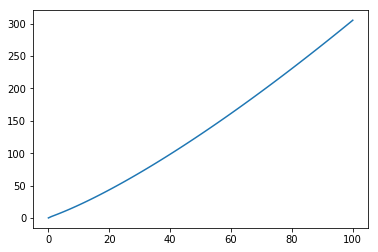

In [262]:
plt.plot(dpsm.y_grid,g_grid)

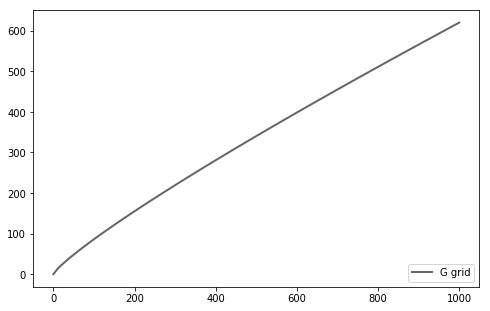

In [318]:
dpsm= DynamicProgrammingSquaredModel(τ = 0.3, y_max= 1000)
def G(self, y,x, k):
        'G is state transition function'
        return (y**.9+ x**.8 +k**.5 )*self.shocks

plt.plot(dpsm.y_grid, G(dpsm, 100,30,70))

g_grid = []    
for i, y in enumerate(dpsm.y_grid):
    ans = np.mean(G(dpsm, y = y, x = dpsm.τ*y, k = (1-dpsm.τ)*y))
    g_grid.append(ans)

g_grid = np.asarray(g_grid)

%matplotlib inline

fig,ax = plt.subplots(figsize=(8,8))
lb = 'G grid'
ax.plot(dpsm.y_grid,g_grid,color = 'black', lw = 2, alpha = 0.6, label = lb)
ax.set_ylim( np.min(g_grid), np.max(g_grid)+1 )
ax.set_xlim( np.min(dpsm.y_grid),np.max(dpsm.y_grid) +1)
ax.legend(loc = 'lower right')
plt.axis('scaled')
plt.show();

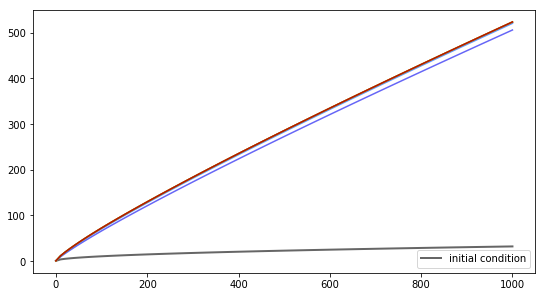

In [329]:
dpsm.graph_agent_value_fun_sequence(n = 10)

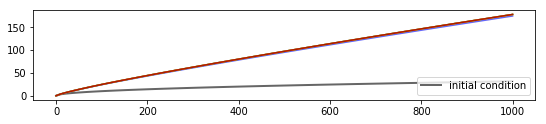

In [330]:
dpsm.graph_principal_value_fun_sequence(n = 10)

In [145]:
# Checking the w-Values are correct
i = 50
y = dpsm.y_grid[i]
x = dpsm.w_xvalues[i]
k = dpsm.v_kvalues[i]
dpsm.w_values[i]
y
x
dpsm.w_func(y = y , x= x , k = k, τ= dpsm.τ)

124.63774957394025

505.05050999999997

54.585908738892606

164.21072931185427

In [ ]:
import matplotlib.pylab as plt

plt.plot(*zip(*sorted(x.items())))
plt.show()
dpsm.vstar_iterations
dpsm.v_iterations

In [334]:
dpsm= DynamicProgrammingSquaredModel(τ = 0.3, y_max= 100)

dpsm.agent_scenario()

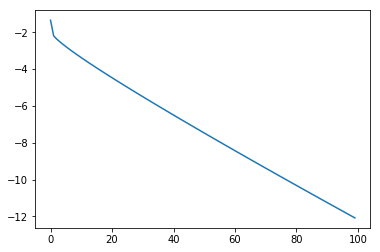

66

64

In [335]:
x ={}
for i,y in enumerate(dpsm.y_grid):
    xmax = dpsm.τ*y
    x[i] = dpsm.v_func(k= dpsm.v_kvalues[i] ,x =xmax,τ = dpsm.τ ,y =y )-dpsm.vstar_values[i]

import matplotlib.pylab as plt

plt.plot(*zip(*sorted(x.items())))
plt.show()
dpsm.vstar_iterations
dpsm.v_iterations

In [7]:
dpsm.vstar_values[80]

90.685843433226012

In [17]:
import numpy as np
from scipy.optimize import minimize
y = dpsm.y_grid[80]
print('y is {}'.format(y))
τ = dpsm.τ
β = dpsm.β
print('xmax is {}'.format(τ*y))
print('kmax is {}'.format((1-τ)*y))

gv = interpolate.interp1d(dpsm.y_grid, dpsm.v_values,fill_value='extrapolate')
def objective2(params):
    k,x = params
    return -dpsm.U(y = y, k = k, τ = τ) - dpsm.β*np.mean( gv( dpsm.G(y = y, x =x, k = k) ) )
k_bound = (1e-10,(1-τ)*y)
x_bound = (1e-10,τ*y)
bnds = (k_bound, x_bound)
x0 = [(1-τ)*y/2,τ*y/2]
sol = minimize(objective2,x0=x0,method = 'SLSQP',bounds = bnds )
#sol.x
print('kstar is {} and xstar is {}'.format(sol.x[0],sol.x[1]))
print('Optimum Value is {}'.format(-objective2(sol.x)))

y is 80.80808272727272
xmax is 24.242424818181814
kmax is 56.5656579090909
kstar is 9.906779212229173 and xstar is 24.242424818180304
Optimum Value is 126.91260584479565


In [18]:
vstar = dpsm.vstar_values[80]
vstar

90.685843433226012

In [97]:

import numpy as np
from scipy.optimize import minimize
y = dpsm.y_grid[80]
print('y is {}'.format(y))
τ = dpsm.τ
β = dpsm.β
print('xmax is {}'.format(τ*y))
print('kmax is {}'.format((1-τ)*y))
#fv = lambda x: np.interp(x, dpsm.y_grid, dpsm.v_values)
gv = interpolate.interp1d(dpsm.y_grid, dpsm.v_values,fill_value='extrapolate')

def objective(params):
    k,x = params
    return x

def constraint1(params):
    k,x = params
    return dpsm.U(y = y, k = k, τ = τ) + dpsm.β*np.mean( gv( dpsm.G(y = y, x =x, k = k) ) ) - vstar

k_bound = (1e-10,(1-τ)*y)
x_bound = (1e-10,τ*y)
bnds = (k_bound, x_bound)
x0 = [(1-τ)*y/2,τ*y/2]
con1 = {'type':'ineq','fun':constraint1}
cons = ([con1])
sol = minimize(objective,x0=x0,method = 'SLSQP',bounds = bnds, constraints= cons )
#sol
#sol.x
print('kstar is {} and xstar is {}'.format(sol.x[0],sol.x[1]))
print('Constraint - Vstar is {}'.format(constraint1(sol.x)))
print('consumer value is {}'.format(constraint1(sol.x)+vstar))

y is 80.80808272727272
xmax is 24.242424818181814
kmax is 56.5656579090909
kstar is 9.922947011751903 and xstar is 10.408350998942286
Constraint - Vstar is -2.323213408317315e-07
consumer value is 90.68584320090467


In [ ]:
xgrid = np.linspace(0,τ*y,20)
kgrid = np.linspace(0,(1-τ)*y,20)

megadic = {}
count = 0
for i,k in enumerate(kgrid):
    for j,x in enumerate(xgrid):
        megadic[count] = (k,x,-objective2([k,x]))
        count+=1

In [99]:
{k: v for k, v in megadic.items() if v[2] >= vstar and v[2] < 92 }

{10: (0.0, 12.759170956937798, 90.926806354865718),
 169: (23.817119119617221, 11.483253861244018, 91.641566278082337),
 189: (26.794259009569373, 11.483253861244018, 90.884495352195231),
 250: (35.725678679425833, 12.759170956937798, 91.603657397625213),
 311: (44.657098349282286, 14.035088052631577, 91.656793835380782),
 372: (53.588518019138746, 15.311005148325357, 90.878081661374694)}

In [97]:
import numpy as np
from scipy.optimize import minimize
y = dpsm.y_grid[80]
print('y is {}'.format(y))
τ = dpsm.τ
β = dpsm.β
print('xmax is {}'.format(τ*y))
print('kmax is {}'.format((1-τ)*y))
#fv = lambda x: np.interp(x, dpsm.y_grid, dpsm.v_values)
fv = interpolate.interp1d(dpsm.y_grid, dpsm.v_values,fill_value='extrapolate')
fw = interpolate.interp1d(dpsm.y_grid, dpsm.w_values,fill_value='extrapolate')

def objective(params):
    k,x = params
    return x

def constraint1(params):
    k,x = params
    return dpsm.U(y = y, k = k, τ = τ) + dpsm.β*np.mean( fv( dpsm.G(y = y, x =x, k = k) ) ) - vstar

k_bound = (1e-10,(1-τ)*y)
x_bound = (1e-10,τ*y)
bnds = (k_bound, x_bound)
x0 = [(1-τ)*y/2,τ*y/2]
con1 = {'type':'ineq','fun':constraint1}
cons = ([con1])
sol = minimize(objective,x0=x0,method = 'SLSQP',bounds = bnds, constraints= cons )
#sol
#sol.x
print('kstar is {} and xstar is {}'.format(sol.x[0],sol.x[1]))
print('Constraint - Vstar is {}'.format(constraint1(sol.x)))
print('consumer value is {}'.format(constraint1(sol.x)+vstar))

y is 80.80808272727272
xmax is 24.242424818181814
kmax is 56.5656579090909
kstar is 9.922947011751903 and xstar is 10.408350998942286
Constraint - Vstar is -2.323213408317315e-07
consumer value is 90.68584320090467
